In [119]:
# requires utm, laspy and salem, available through pip

%matplotlib inline
import laspy 
import pylab as pl
import numpy as np
from scipy.interpolate import griddata

import utm
import matplotlib

pl.rcParams['figure.figsize'] = (8, 6.0)
pl.rcParams['font.size'] = 16
#pl.rcParams['font.family'] = 'sans-serif'
pl.rcParams['axes.linewidth'] = 1.5 #set the value globally

matplotlib.rcParams['font.family'] = 'CMU Sans Serif'

In [16]:
las = laspy.read("/Users/jmsantander/swgo/sites/CerroVecar-georeferenced_model.laz")

In [33]:
xx = las.xyz[:,0]
yy = las.xyz[:,1]
zi = las.xyz[:,2]

xi = []
yi = []

for i in np.arange(len(xx)):
    lati, lngi = utm.to_latlon(xx[i], yy[i], 19, 'M')
    xi.append(lngi)
    yi.append(lati)

xmin = np.min(xi)
xmax = np.max(xi)
ymin = np.min(yi)
ymax = np.max(yi)

npoints = 1000

In [38]:
file_lng = open('/Users/jmsantander/swgo/sites/lng_vecar.dat','w')
for lng_w in xi:
    file_lng.write(str(lng_w)+"\n")
    
file_lat = open('/Users/jmsantander/swgo/sites/lat_vecar.dat','w')
for lat_w in xi:
    file_lat.write(str(lat_w)+"\n")

In [39]:
zmin = np.min(zi)
zmax = np.max(zi)

In [40]:
xs = np.linspace(xmin, xmax, npoints)
ys = np.linspace(ymin, ymax, npoints)

In [42]:
zs = griddata((xi, yi), zi.flatten(), 
              (xs[None,:], ys[:,None]), method='nearest')

In [43]:
mask, _, _ = np.histogram2d(xi, yi, range=([xmin,xmax],[ymin,ymax]),bins=npoints)

mask[mask == 0] = np.nan
mask[mask > 1] = 1

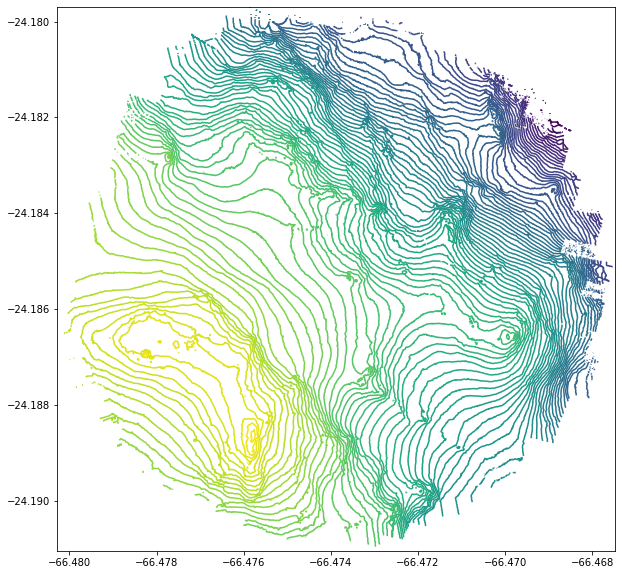

In [49]:
fig = pl.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#c = ax.pcolormesh(xs, ys, zs,shading='auto')

zspacing = 2. # 2 m spacing for contour lines
nlevels = np.linspace(zmin, zmax, int((zmax-zmin)/zspacing))

cont = ax.contour(xs, ys, mask*zs, levels=nlevels)

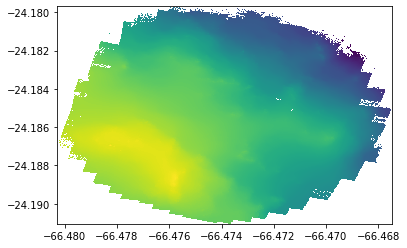

In [45]:
pl.pcolormesh(xs, ys, zs*mask)

In [46]:
from salem import DataLevels, GoogleVisibleMap, Map


/opt/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


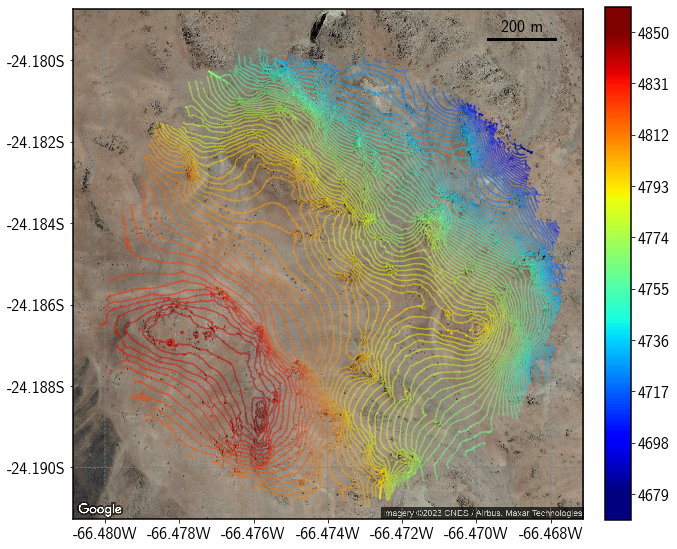

In [120]:
# prepare the figure
fig = pl.figure(figsize=(10,10))

ax = fig.add_subplot(111)

# I you need to do a lot of maps you might want
# to use an API key and set it here with key='YOUR_API_KEY'
g = GoogleVisibleMap(x=[-66.48, -66.468], y=[-24.190, -24.180],
                     scale=2,  # scale is for more details
                     maptype='satellite')  # try out also: 'terrain'

ggl_img = g.get_vardata()
ax.imshow(ggl_img)

# make a map of the same size as the image (no country borders)
sm = Map(g.grid, factor=1, countries=False)
sm.set_rgb(ggl_img)  # add the background rgb image
sm.set_scale_bar(location=(0.88, 0.94))  # add scale
sm.visualize(ax=ax)  # plot it

cmap = pl.get_cmap('jet')

colors = [cmap(x) for x in np.arange(len(cont.allsegs))/len(cont.allsegs)]


for lev in np.arange(len(cont.allsegs)):
    col = colors[lev]
    for seg in cont.allsegs[lev]:
        xgo, ygo = sm.grid.transform(seg[:,0], seg[:,1])
        line = pl.plot(xgo, ygo, color=col, alpha=0.5)
        
#norm = matplotlib.colors.Normalize(vmin=zmin, vmax=zmax)

#cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
#                                norm=norm)

norm = matplotlib.colors.Normalize(vmin=zmin,vmax=zmax)
smc = pl.cm.ScalarMappable(cmap=cmap, norm=norm)
smc.set_array([])
pl.colorbar(
            smc, ticks=[np.round(t) for t in np.linspace(zmin,zmax,10)], 
            boundaries=np.arange(zmin-10,zmax+10,1),
            fraction=0.046, pad=0.04
           )